#  Identify a tumor in brain radiography images


  Ive been working on this project in order to study by myself Convolutional Neural Network, Deep Learning and what's going in the "Artificial Intelligence". I'm fascinating about cognitives sciences and neuromorphology. So i was curious about creating intelligence using neural network. I wanted to go deeper to see how cleverness is create and to compare it about what i know from human brain. What a perfect way to do that by classify brain tumors.

A brain tumor is a mass or growth of abnormal cells in your brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.


Nowadays, there wouldn't have any means of prevention against brain tumors but it counts more than 220 000 deaths in 2015.
This kind of project, used by clinics, hospitals or research centers would allow to classify the different patients and treat them according to results. For patients, this would increase their chance of survival. Indeed, the sooner the tumor is detected and treated, the sooner the patient will be cured without the tumor having time to become cancerous. Moreover, it would be a financial benefit and human economy compared to the means deployed.


### Library used

In [1]:
import numpy as np 
import pandas as pd
import os
import time
import cv2
import random
import requests
from openpyxl import Workbook
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras import utils, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Dataset used

We got 4600 radiography images of brain taken over different angles (jpg et tiff format). The whole dataset comes from Kaggle :

https://www.kaggle.com/code/boneacrabonjac/brain-tumor-classification-with-simple-cnn/data

In [2]:
dataset_path = r".\kaggle\input\Brain Tumor Data Set\Brain Tumor Data Set"

#image matrix normalization + pick up 20% of dataset as validation part
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99)) 

train = gen.flow_from_directory(dataset_path,
                               target_size = (150,150), #resize dataset images
                               batch_size = 256, 
                               class_mode = "binary", #label 0 or 1
                               color_mode = "rgb", #analysis as rgb rather than grayscale
                               shuffle = True,
                               seed = 129,
                               subset = "training")

val = gen.flow_from_directory(dataset_path,
                               target_size = (150,150),
                               batch_size = 64,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 129,
                               subset = "validation")

classes = val.class_indices
classes

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


{'Brain Tumor': 0, 'Healthy': 1}

### CNN Building 


I want to compare different convolutional neural networks to see if a specific shape turns to be more efficient.
    Most of web examples use few layers with the power of 2 number of neurons. Here, Likely, due to the level of classification which should not ask a lot of complexity, a short network (few layers) will probably be the most efficient.
    
  To do that, i create 30 network with a random number of layers between 1 and 10. Each layer has a random number of layers between 2 and 300.

In [3]:
nb_network = 30

#The table will contain networks characteristics
Tab_networks = [["numéro","nb_layer","nb_neurons","accuracy","val_accuracy","loss","val_loss","timing","nb_params","counter"]]

for i in range (nb_network):
    time_start = time.perf_counter() #pick up the calculation time for each network
    network_featu = [] #list of network characteristics
    network_featu.append(i+1)
    model_1 = keras.Sequential()
    model_1.add(InputLayer(input_shape=(150,150,3)))
    model_1.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same")) #create 32 feature-maps with different image features
    model_1.add(MaxPool2D()) #split up the image size
    model_1.add(Conv2D(filters=16,kernel_size=3, activation="relu", padding="same"))
    model_1.add(MaxPool2D())
    model_1.add(Flatten()) #turn the image into a vector

    earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True) #function which allow to stop the training when the error stop to decrease
    
    
    nb_layer = random.randint(1,10) #create neural network SNN with random number of layers and random number of neurons inside
    network_featu.append((nb_layer+2)) #we want to put in the table how many layers there are per network. Add 2 for the input and output layers
    list_neurons = [21904 ] #we want to see how many neurons there is per layer
    nb_params = 0 #We want to see how many params are needed for each network
    for j in range (nb_layer):
        nb_neurons = random.randint(2,300)
        list_neurons.append(nb_neurons)
        
        
        model_1.add(Dense(nb_neurons, activation='relu')) #the SNN part is made only by Dense layer
        model_1.add(BatchNormalization()) #followed by normalization and dropout function
        model_1.add(Dropout(rate=0.3))
        
        nb_params = nb_neurons*4 + nb_params
    
    list_neurons.append(1) #Add the ouput layer into the list of layers
    
    for k in range(len(list_neurons)-1): #calculate the number of params needed
        nb_params = list_neurons[k]*list_neurons[k+1]+list_neurons[k+1] + nb_params
        
    network_featu.append(list_neurons)
 
    model_1.add(Dense(1, activation="sigmoid")) #add the output layer, only 1 neuron cause it's a binary system

    model_1.compile(optimizer=Adam(1e-4),loss = BinaryCrossentropy(),metrics=['accuracy'])
    model_1.summary()


    history1 = model_1.fit(train,verbose=2,callbacks = [earlystopping],epochs=20,validation_data=(val))
    time_stop = time.perf_counter()
    
    
    network_featu.append(history1.history["accuracy"][-1])
    network_featu.append(history1.history["val_accuracy"][-1])
    network_featu.append(history1.history["loss"][-1])
    network_featu.append(history1.history["val_loss"][-1])
    network_featu.append(time_stop - time_start)
    network_featu.append((nb_params+5088)) #5088 for the filters which have constant params number
    network_featu.append(0) #we put 0 in the counter values, then we will classify networks by adding point according to their range
    Tab_networks.append(network_featu)  #Tableau des caractéristiques de chaque network
    
    
    model_1.save(f"save_neuroNetworkModel_{i+1}.h5") #save each network for being able to use the best one later
        
    
print(Tab_networks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21904)             0         
                                                                 
 dense (Dense)               (None, 196)               4

 max_pooling2d_3 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 21904)             0         
                                                                 
 dense_11 (Dense)            (None, 167)               3658135   
                                                                 
 batch_normalization_10 (Bat  (None, 167)              668       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 167)               0         
                                                                 
 dense_12 (Dense)            (None, 139)               23352     
                                                                 
 batch_normalization_11 (Bat  (None, 139)              556       
 chNormali

                                                                 
 dense_21 (Dense)            (None, 292)               3504      
                                                                 
 batch_normalization_19 (Bat  (None, 292)              1168      
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 292)               0         
                                                                 
 dense_22 (Dense)            (None, 140)               41020     
                                                                 
 batch_normalization_20 (Bat  (None, 140)              560       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 140)               0         
                                                                 
 dense_23 

 flatten_4 (Flatten)         (None, 21904)             0         
                                                                 
 dense_32 (Dense)            (None, 203)               4446715   
                                                                 
 batch_normalization_28 (Bat  (None, 203)              812       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 203)               0         
                                                                 
 dense_33 (Dense)            (None, 299)               60996     
                                                                 
 batch_normalization_29 (Bat  (None, 299)              1196      
 chNormalization)                                                
                                                                 
 dropout_29 (Dropout)        (None, 299)               0         
          

Epoch 3/20
15/15 - 81s - loss: 0.4151 - accuracy: 0.8082 - val_loss: 0.6602 - val_accuracy: 0.8009 - 81s/epoch - 5s/step
Epoch 4/20
15/15 - 82s - loss: 0.3658 - accuracy: 0.8378 - val_loss: 0.6539 - val_accuracy: 0.8313 - 82s/epoch - 5s/step
Epoch 5/20
15/15 - 80s - loss: 0.3335 - accuracy: 0.8661 - val_loss: 0.6460 - val_accuracy: 0.7998 - 80s/epoch - 5s/step
Epoch 6/20
15/15 - 80s - loss: 0.2842 - accuracy: 0.9008 - val_loss: 0.6236 - val_accuracy: 0.7943 - 80s/epoch - 5s/step
Epoch 7/20
15/15 - 79s - loss: 0.2637 - accuracy: 0.9071 - val_loss: 0.6316 - val_accuracy: 0.7922 - 79s/epoch - 5s/step
Epoch 8/20
15/15 - 81s - loss: 0.2312 - accuracy: 0.9329 - val_loss: 0.6154 - val_accuracy: 0.7530 - 81s/epoch - 5s/step
Epoch 9/20
15/15 - 80s - loss: 0.2083 - accuracy: 0.9402 - val_loss: 0.6071 - val_accuracy: 0.8455 - 80s/epoch - 5s/step
Epoch 10/20
15/15 - 80s - loss: 0.1934 - accuracy: 0.9500 - val_loss: 0.5904 - val_accuracy: 0.8150 - 80s/epoch - 5s/step
Epoch 11/20
15/15 - 81s - loss:

15/15 - 82s - loss: 0.8304 - accuracy: 0.5162 - val_loss: 0.6886 - val_accuracy: 0.5462 - 82s/epoch - 5s/step
Epoch 6/20
15/15 - 83s - loss: 0.8255 - accuracy: 0.5189 - val_loss: 0.6891 - val_accuracy: 0.5462 - 83s/epoch - 6s/step
Epoch 7/20
15/15 - 81s - loss: 0.8307 - accuracy: 0.5069 - val_loss: 0.6860 - val_accuracy: 0.5462 - 81s/epoch - 5s/step
Epoch 8/20
15/15 - 82s - loss: 0.8058 - accuracy: 0.5289 - val_loss: 0.6841 - val_accuracy: 0.5462 - 82s/epoch - 5s/step
Epoch 9/20
15/15 - 81s - loss: 0.8094 - accuracy: 0.5189 - val_loss: 0.6787 - val_accuracy: 0.5462 - 81s/epoch - 5s/step
Epoch 10/20
15/15 - 82s - loss: 0.8242 - accuracy: 0.5086 - val_loss: 0.6781 - val_accuracy: 0.5462 - 82s/epoch - 5s/step
Epoch 11/20
15/15 - 81s - loss: 0.8060 - accuracy: 0.5344 - val_loss: 0.6819 - val_accuracy: 0.5462 - 81s/epoch - 5s/step
Epoch 12/20
15/15 - 82s - loss: 0.8117 - accuracy: 0.5192 - val_loss: 0.6818 - val_accuracy: 0.5528 - 82s/epoch - 5s/step
Epoch 13/20
15/15 - 82s - loss: 0.7855 -

 conv2d_16 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 21904)             0         
                                                                 
 dense_63 (Dense)            (None, 101)               2212405   
                                                                 
 batch_normalization_55 (Bat  (None, 101)              404       
 chNormali

Epoch 6/20
15/15 - 82s - loss: 0.5998 - accuracy: 0.6963 - val_loss: 0.6897 - val_accuracy: 0.4538 - 82s/epoch - 5s/step
Epoch 7/20
15/15 - 82s - loss: 0.5609 - accuracy: 0.7272 - val_loss: 0.6982 - val_accuracy: 0.4538 - 82s/epoch - 5s/step
Epoch 8/20
15/15 - 81s - loss: 0.5177 - accuracy: 0.7555 - val_loss: 0.7186 - val_accuracy: 0.4538 - 81s/epoch - 5s/step
Epoch 9/20
15/15 - 81s - loss: 0.4647 - accuracy: 0.7870 - val_loss: 0.7114 - val_accuracy: 0.4538 - 81s/epoch - 5s/step
Epoch 10/20
15/15 - 82s - loss: 0.4173 - accuracy: 0.8060 - val_loss: 0.7315 - val_accuracy: 0.4538 - 82s/epoch - 5s/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                    

                                                                 
 batch_normalization_67 (Bat  (None, 103)              412       
 chNormalization)                                                
                                                                 
 dropout_67 (Dropout)        (None, 103)               0         
                                                                 
 dense_79 (Dense)            (None, 131)               13624     
                                                                 
 batch_normalization_68 (Bat  (None, 131)              524       
 chNormalization)                                                
                                                                 
 dropout_68 (Dropout)        (None, 131)               0         
                                                                 
 dense_80 (Dense)            (None, 153)               20196     
                                                                 
 batch_nor

Epoch 20/20
15/15 - 81s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.9989 - 81s/epoch - 5s/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 21904)             0       

                                                                 
 batch_normalization_81 (Bat  (None, 213)              852       
 chNormalization)                                                
                                                                 
 dropout_81 (Dropout)        (None, 213)               0         
                                                                 
 dense_96 (Dense)            (None, 127)               27178     
                                                                 
 batch_normalization_82 (Bat  (None, 127)              508       
 chNormalization)                                                
                                                                 
 dropout_82 (Dropout)        (None, 127)               0         
                                                                 
 dense_97 (Dense)            (None, 138)               17664     
                                                                 
 batch_nor

Epoch 5/20
15/15 - 82s - loss: 0.5813 - accuracy: 0.7172 - val_loss: 0.6468 - val_accuracy: 0.7791 - 82s/epoch - 5s/step
Epoch 6/20
15/15 - 81s - loss: 0.5612 - accuracy: 0.7253 - val_loss: 0.6496 - val_accuracy: 0.6942 - 81s/epoch - 5s/step
Epoch 7/20
15/15 - 82s - loss: 0.5164 - accuracy: 0.7541 - val_loss: 0.6280 - val_accuracy: 0.7519 - 82s/epoch - 5s/step
Epoch 8/20
15/15 - 82s - loss: 0.4708 - accuracy: 0.7751 - val_loss: 0.6005 - val_accuracy: 0.8205 - 82s/epoch - 5s/step
Epoch 9/20
15/15 - 82s - loss: 0.4414 - accuracy: 0.7927 - val_loss: 0.5791 - val_accuracy: 0.8324 - 82s/epoch - 5s/step
Epoch 10/20
15/15 - 82s - loss: 0.4047 - accuracy: 0.8166 - val_loss: 0.5556 - val_accuracy: 0.8498 - 82s/epoch - 5s/step
Epoch 11/20
15/15 - 81s - loss: 0.3741 - accuracy: 0.8348 - val_loss: 0.5141 - val_accuracy: 0.8727 - 81s/epoch - 5s/step
Epoch 12/20
15/15 - 82s - loss: 0.3380 - accuracy: 0.8549 - val_loss: 0.4998 - val_accuracy: 0.8847 - 82s/epoch - 5s/step
Epoch 13/20
15/15 - 80s - los

                                                                 
 batch_normalization_92 (Bat  (None, 275)              1100      
 chNormalization)                                                
                                                                 
 dropout_92 (Dropout)        (None, 275)               0         
                                                                 
 dense_110 (Dense)           (None, 1)                 276       
                                                                 
Total params: 905,006
Trainable params: 904,106
Non-trainable params: 900
_________________________________________________________________
Epoch 1/20
15/15 - 84s - loss: 0.8004 - accuracy: 0.5925 - val_loss: 0.6873 - val_accuracy: 0.6137 - 84s/epoch - 6s/step
Epoch 2/20
15/15 - 82s - loss: 0.6407 - accuracy: 0.6838 - val_loss: 0.6698 - val_accuracy: 0.7193 - 82s/epoch - 5s/step
Epoch 3/20
15/15 - 81s - loss: 0.5730 - accuracy: 0.7139 - val_loss: 0.6607 - val_accuracy

 dropout_101 (Dropout)       (None, 58)                0         
                                                                 
 dense_120 (Dense)           (None, 171)               10089     
                                                                 
 batch_normalization_102 (Ba  (None, 171)              684       
 tchNormalization)                                               
                                                                 
 dropout_102 (Dropout)       (None, 171)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 172       
                                                                 
Total params: 2,802,109
Trainable params: 2,799,585
Non-trainable params: 2,524
_________________________________________________________________
Epoch 1/20
15/15 - 87s - loss: 0.8931 - accuracy: 0.4971 - val_loss: 0.6912 - val_accuracy: 0.5462 - 87s/epoch - 6s/step
Epoch 2

 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 21904)             0         
                                                                 
 dense_128 (Dense)           (None, 29)                635245    
                                                                 
 batch_nor

                                                                 
 dropout_115 (Dropout)       (None, 27)                0         
                                                                 
 dense_137 (Dense)           (None, 155)               4340      
                                                                 
 batch_normalization_116 (Ba  (None, 155)              620       
 tchNormalization)                                               
                                                                 
 dropout_116 (Dropout)       (None, 155)               0         
                                                                 
 dense_138 (Dense)           (None, 38)                5928      
                                                                 
 batch_normalization_117 (Ba  (None, 38)               152       
 tchNormalization)                                               
                                                                 
 dropout_1

 tchNormalization)                                               
                                                                 
 dropout_120 (Dropout)       (None, 172)               0         
                                                                 
 dense_144 (Dense)           (None, 27)                4671      
                                                                 
 batch_normalization_121 (Ba  (None, 27)               108       
 tchNormalization)                                               
                                                                 
 dropout_121 (Dropout)       (None, 27)                0         
                                                                 
 dense_145 (Dense)           (None, 1)                 28        
                                                                 
Total params: 3,778,675
Trainable params: 3,778,277
Non-trainable params: 398
________________________________________________________________

Epoch 10/20
15/15 - 80s - loss: 0.4581 - accuracy: 0.7821 - val_loss: 0.5884 - val_accuracy: 0.6942 - 80s/epoch - 5s/step
Epoch 11/20
15/15 - 80s - loss: 0.4557 - accuracy: 0.7984 - val_loss: 0.5957 - val_accuracy: 0.6736 - 80s/epoch - 5s/step
Epoch 12/20
15/15 - 80s - loss: 0.4261 - accuracy: 0.8044 - val_loss: 0.5534 - val_accuracy: 0.7671 - 80s/epoch - 5s/step
Epoch 13/20
15/15 - 80s - loss: 0.3747 - accuracy: 0.8343 - val_loss: 0.5365 - val_accuracy: 0.7410 - 80s/epoch - 5s/step
Epoch 14/20
15/15 - 79s - loss: 0.3378 - accuracy: 0.8593 - val_loss: 0.5182 - val_accuracy: 0.7748 - 79s/epoch - 5s/step
Epoch 15/20
15/15 - 82s - loss: 0.2974 - accuracy: 0.8786 - val_loss: 0.4978 - val_accuracy: 0.7867 - 82s/epoch - 5s/step
Epoch 16/20
15/15 - 80s - loss: 0.2710 - accuracy: 0.8859 - val_loss: 0.4383 - val_accuracy: 0.8205 - 80s/epoch - 5s/step
Epoch 17/20
15/15 - 81s - loss: 0.2440 - accuracy: 0.9044 - val_loss: 0.4105 - val_accuracy: 0.8313 - 81s/epoch - 5s/step
Epoch 18/20
15/15 - 80s 

                                                                 
 flatten_26 (Flatten)        (None, 21904)             0         
                                                                 
 dense_158 (Dense)           (None, 124)               2716220   
                                                                 
 batch_normalization_132 (Ba  (None, 124)              496       
 tchNormalization)                                               
                                                                 
 dropout_132 (Dropout)       (None, 124)               0         
                                                                 
 dense_159 (Dense)           (None, 297)               37125     
                                                                 
 batch_normalization_133 (Ba  (None, 297)              1188      
 tchNormalization)                                               
                                                                 
 dropout_1

Epoch 7/20
15/15 - 80s - loss: 0.1692 - accuracy: 0.9421 - val_loss: 0.5704 - val_accuracy: 0.8335 - 80s/epoch - 5s/step
Epoch 8/20
15/15 - 79s - loss: 0.1326 - accuracy: 0.9530 - val_loss: 0.5415 - val_accuracy: 0.8575 - 79s/epoch - 5s/step
Epoch 9/20
15/15 - 81s - loss: 0.1097 - accuracy: 0.9609 - val_loss: 0.5134 - val_accuracy: 0.9336 - 81s/epoch - 5s/step
Epoch 10/20
15/15 - 81s - loss: 0.0863 - accuracy: 0.9726 - val_loss: 0.4980 - val_accuracy: 0.9129 - 81s/epoch - 5s/step
Epoch 11/20
15/15 - 81s - loss: 0.0734 - accuracy: 0.9780 - val_loss: 0.4670 - val_accuracy: 0.9684 - 81s/epoch - 5s/step
Epoch 12/20
15/15 - 86s - loss: 0.0550 - accuracy: 0.9875 - val_loss: 0.4246 - val_accuracy: 0.9510 - 86s/epoch - 6s/step
Epoch 13/20
15/15 - 86s - loss: 0.0507 - accuracy: 0.9867 - val_loss: 0.3825 - val_accuracy: 0.9793 - 86s/epoch - 6s/step
Epoch 14/20
15/15 - 82s - loss: 0.0378 - accuracy: 0.9927 - val_loss: 0.3503 - val_accuracy: 0.9815 - 82s/epoch - 5s/step
Epoch 15/20
15/15 - 81s - l

Epoch 6/20
15/15 - 79s - loss: 0.8607 - accuracy: 0.5249 - val_loss: 0.6928 - val_accuracy: 0.5462 - 79s/epoch - 5s/step
Epoch 7/20
15/15 - 79s - loss: 0.8682 - accuracy: 0.5208 - val_loss: 0.6945 - val_accuracy: 0.5462 - 79s/epoch - 5s/step
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
         

#### Turn the table of networks features into xlsx

In [4]:
def creationwb(L):
    wb=Workbook()

    ws1 = wb.create_sheet("comparaison CNN") #create an excel sheet
        
    # We create the excel table by copy/past cell by cell from the last table
    for ligne in range (1,L.shape[0]+1) :
        for colonne in range (1,L.shape[1]+1):
            ws1.cell(row= ligne, column = colonne ,value = str(L[ligne-1][colonne-1]) )
            
   
    del wb["Sheet"]
    wb.save("comparaison_CNN.xlsx")
    return print("Excel file has been created ;) ")



Tab2 = np.array(Tab_networks)
creationwb(Tab2)

Excel file has been created ;) 


C:\Users\yanna\AppData\Local\Temp\ipykernel_25936\866520971.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Tab2 = np.array(Tab_networks)


#### Showing the Excel file : 

In [5]:
df = pd.read_excel(r'.\comparaison_CNN.xlsx')
df.head(nb_network)

,numéro,nb_layer,nb_neurons,accuracy,val_accuracy,loss,val_loss,timing,nb_params,counter
0,1,12,"[20000, 196, 129, 120, 12, 180, 74, 192, 102, ...",0.518337,0.524483,0.818051,0.699107,1063.959940,4081473,0
1,2,5,"[20000, 167, 139, 242, 1]",0.998098,0.991295,0.017677,0.234063,1615.629069,3404922,0
2,3,10,"[20000, 191, 223, 112, 300, 251, 11, 292, 140, 1]",0.540342,0.453754,0.808556,0.718495,485.534942,4056151,0
3,4,9,"[20000, 88, 28, 116, 205, 148, 258, 104, 1]",0.586254,0.453754,0.773609,0.707768,480.939104,1894776,0
4,5,8,"[20000, 203, 299, 35, 168, 296, 102, 1]",0.955990,0.928183,0.132466,0.272835,1623.835066,4227668,0
5,6,4,"[20000, 43, 13, 1]",0.989405,0.990207,0.096916,0.379026,1611.637918,865941,0
6,7,11,"[20000, 233, 291, 136, 202, 36, 259, 25, 214, ...",0.541972,0.574538,0.794298,0.683559,1237.625452,4896281,0
7,8,12,"[20000, 39, 4, 160, 145, 94, 197, 120, 123, 96...",0.508557,0.453754,0.848365,0.701335,490.550577,901635,0
8,9,3,"[20000, 101, 1]",0.999728,0.996736,0.015159,0.234269,1609.298973,2025695,0
9,10,7,"[20000, 23, 182, 103, 165, 296, 1]",0.806031,0.453754,0.417346,0.731532,816.959935,557997,0


### Comparing and Ranking different networks


As mentioned above, we want to compare the networks each other in order to see if one model turns to be better than others.
So we range networks according to their features and give them points accordind to their ranking.

In [6]:
Tab2 = np.delete(Tab_networks,0,axis=0) #We delete the strings from the table to study easier different features

Tab_accuracy_sorted = sorted(Tab2 ,key=lambda x: x[3]) #Sorte networks according to their accuracy 
print(" Neural Network sorted by accuracy :", np.array(Tab_accuracy_sorted))
for i in range(nb_network):
    Tab_accuracy_sorted[i][-1] = Tab_accuracy_sorted[i][-1]+i #We give points to networks according to their ranking
    
    
#We do the same for the loss
Tab_loss_sorted = sorted(Tab_accuracy_sorted ,key=lambda x: x[5], reverse = True)
print(" Neural Network sorted by loss  :", np.array(Tab_loss_sorted))
for i in range(nb_network):
    Tab_loss_sorted[i][-1] = Tab_loss_sorted[i][-1] + i 
  
 #We do the same for the time execution
Tab_time_sorted = sorted(Tab_loss_sorted ,key=lambda x: x[7], reverse = True)
print(" Neural Network sorted by time execution :", np.array(Tab_time_sorted))
for i in range(nb_network):
    Tab_time_sorted[i][-1] = Tab_time_sorted[i][-1]+i
    
 #We do the same for the params weight
Tab_params_sorted = sorted(Tab_time_sorted ,key=lambda x: x[8], reverse = True)
print(" Neural Network sorted by their params weight :", np.array(Tab_params_sorted))
for i in range(nb_network):
    Tab_params_sorted[i][-1] = Tab_params_sorted[i][-1]+i
    

    

 Neural Network sorted by accuracy : [[8 12 list([20000, 39, 4, 160, 145, 94, 197, 120, 123, 96, 52, 1])
  0.5085574388504028 0.4537540674209595 0.8483645915985107
  0.701334536075592 490.5505769000001 901635 0]
 [12 12 list([20000, 8, 124, 31, 221, 159, 103, 131, 153, 180, 272, 1])
  0.5164357423782349 0.4537540674209595 0.8399168848991394
  0.704581081867218 735.8547199000004 345510 0]
 [1 12 list([20000, 196, 129, 120, 12, 180, 74, 192, 102, 219, 162, 1])
  0.5183374285697937 0.5244831442832947 0.8180505633354187
  0.6991073489189148 1063.9599401 4081473 0]
 [29 12 list([20000, 46, 188, 284, 165, 147, 147, 10, 206, 20, 110, 1])
  0.5207824110984802 0.5462459325790405 0.8682169914245605
  0.6944994926452637 562.4408766999986 1096428 0]
 [19 12 list([20000, 122, 45, 5, 177, 274, 61, 53, 296, 58, 171, 1])
  0.5313773155212402 0.5462459325790405 0.7909501194953918
  0.694753885269165 734.5724334000006 2569389 0]
 [3 10 list([20000, 191, 223, 112, 300, 251, 11, 292, 140, 1])
  0.54034227

C:\Users\yanna\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


Finaly, we sorte the table to show off which network have the best mark. This will be the studied network for next parts.



In [7]:
Tab_counter_sorted = sorted(Tab_params_sorted ,key=lambda x: x[9], reverse = True)

print("Le réseau le plus performant serait le numéro :",Tab_counter_sorted[0][0], "composé de :", Tab_counter_sorted[0][1] ,"couches de neurones, composées de :", Tab_counter_sorted[0][2],"neurones respectivement.")

Nbest_network = int(Tab_counter_sorted[0][0])




Le réseau le plus performant serait le numéro : 9 composé de : 3 couches de neurones, composées de : [20000, 101, 1] neurones respectivement.


In [17]:
def creationwb(L):
    wb=Workbook()

    ws1 = wb.create_sheet("comparaison CNN") #create an excel sheet
        
    # We create the excel table by copy/past cell by cell from the last table
    for ligne in range (1,L.shape[0]+1) :
        for colonne in range (1,L.shape[1]+1):
            ws1.cell(row= ligne, column = colonne ,value = str(L[ligne-1][colonne-1]) )
            
   
    del wb["Sheet"]
    wb.save("sorted_network_CNN.xlsx")
    return print("Excel file has been created ;) ")



Tab2 = np.array(Tab_counter_sorted)
creationwb(Tab2)

df = pd.read_excel(r'.\sorted_network_CNN.xlsx')
df.head(nb_network)

Excel file has been created ;) 


,9,3,"[20000, 101, 1]",0.9997283220291138,0.9967355728149414,0.015159226953983307,0.23426935076713562,1609.2989731000016,2025695,90
0,11,3,"[20000, 42, 1]",0.998370,0.994559,0.034102,0.251978,1615.980849,845341,84
1,24,4,"[20000, 172, 27, 1]",0.998642,0.947769,0.037105,0.331071,1602.586603,3450755,81
2,6,4,"[20000, 43, 13, 1]",0.989405,0.990207,0.096916,0.379026,1611.637918,865941,79
3,17,3,"[20000, 195, 1]",1.000000,0.994559,0.005084,0.215568,1622.376327,3906259,78
4,23,4,"[20000, 31, 40, 1]",0.974735,0.822633,0.114898,0.414061,1610.043071,626724,78
5,2,5,"[20000, 167, 139, 242, 1]",0.998098,0.991295,0.017677,0.234063,1615.629069,3404922,75
6,18,5,"[20000, 39, 136, 275, 1]",0.985330,0.902067,0.051743,0.242710,1625.862362,830318,75
7,10,7,"[20000, 23, 182, 103, 165, 296, 1]",0.806031,0.453754,0.417346,0.731532,816.959935,557997,68
8,13,4,"[20000, 240, 296, 1]",1.000000,0.998912,0.005313,0.233002,1631.778726,4879105,64
9,27,6,"[20000, 124, 297, 300, 6, 1]",0.980440,0.980413,0.108824,0.276870,1617.634979,2616458,64


In [8]:
#load the best network according to last part caracteristics
loaded_model = tf.keras.models.load_model(f"save_neuroNetworkModel_{Nbest_network}.h5") 

### Display of the evolution of our model according to the epochs

In [26]:

model_best = keras.Sequential()
model_best.add(InputLayer(input_shape=(150,150,3)))
model_best.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same")) #create 32 feature-maps with different image features
model_best.add(MaxPool2D()) #split up the image size
model_best.add(Conv2D(filters=16,kernel_size=3, activation="relu", padding="same"))
model_best.add(MaxPool2D())
model_best.add(Flatten()) #turn the image into a vector

earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True) #function which allow to stop the training when the error stop to decrease
    
    
for k in range (len(Tab_counter_sorted[0][2])-2):
    model_best.add(Dense(Tab_counter_sorted[0][2][k+1], activation='relu')) #the SNN part is made only by Dense layer
    model_best.add(BatchNormalization()) #followed by normalization and dropout function
    model_best.add(Dropout(rate=0.3))
        
model_best.add(Dense(1, activation="sigmoid")) #add the output layer, only 1 neuron cause it's a binary system

model_best.compile(optimizer=Adam(1e-4),loss = BinaryCrossentropy(),metrics=['accuracy'])
model_best.summary()


history_best_model = model_best.fit(train,verbose=2,callbacks = [earlystopping],epochs=20,validation_data=(val))
    

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 37, 37, 16)       0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 21904)             0         
                                                                 
 dense_184 (Dense)           (None, 101)             

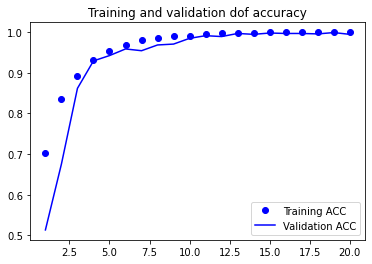

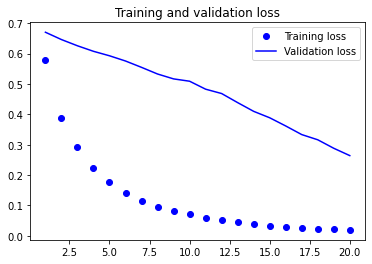

In [27]:
acc = history_best_model.history['accuracy']
val_acc = history_best_model.history['val_accuracy']

loss = history_best_model.history['loss']
val_loss = history_best_model.history['val_loss']


x_epochs = range(1, len(acc) + 1)


plt.plot(x_epochs, acc, 'bo', label='Training ACC')
plt.plot(x_epochs, val_acc, 'b', label='Validation ACC')
plt.title("Training and validation dof accuracy")
plt.legend()

plt.figure()
plt.plot(x_epochs, loss, 'bo', label='Training loss')
plt.plot(x_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



### Neural Network Graph


Amélioration : (extension prochaine version : le rendre dynamique)

### Understanding CNN filters

As explained before, i want to go deeper in what the clever network see and do. That's why it could be interesting to show how the image is perceived in filters


Shape of the image (23581,)


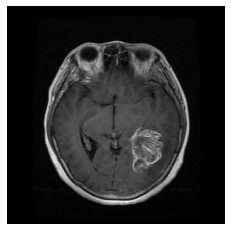

-----------------------------------------------------
1st convolutionnal layer
1/1 [==============================] - 0s 71ms/step
conv2d_16 | Features Shape: (1, 150, 150, 32)
Dimension 32
--------
1nd Pooling
1/1 [==============================] - 0s 64ms/step
max_pooling2d_16 | Features Shape: (1, 75, 75, 32)
Dimension 32
-----------------------------------------------------
-----------------------------------------------------
2st convolutionnal layer
1/1 [==============================] - 0s 86ms/step
conv2d_17 | Features Shape: (1, 75, 75, 16)
Dimension 16
--------
2nd Pooling
1/1 [==============================] - 0s 100ms/step
max_pooling2d_17 | Features Shape: (1, 37, 37, 16)
Dimension 16
-----------------------------------------------------


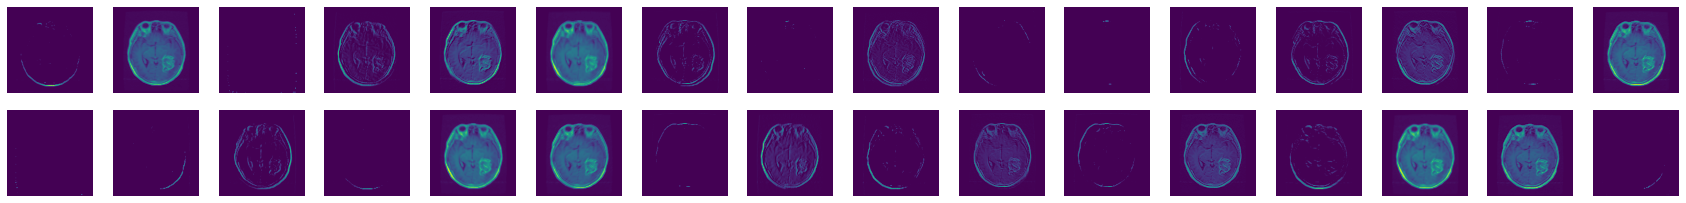

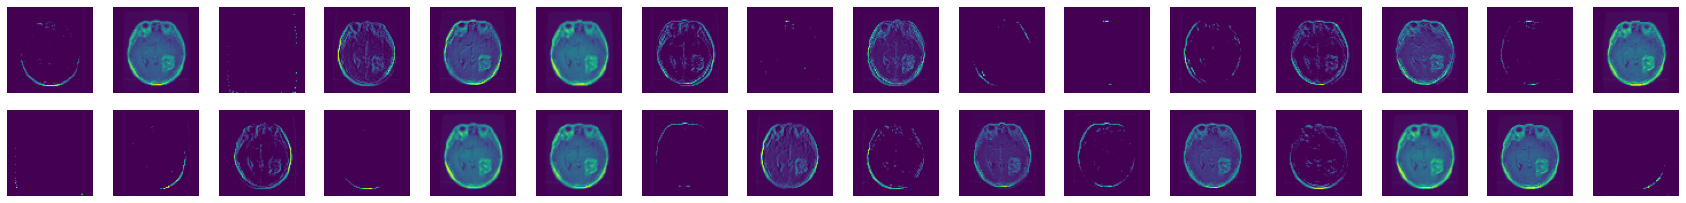

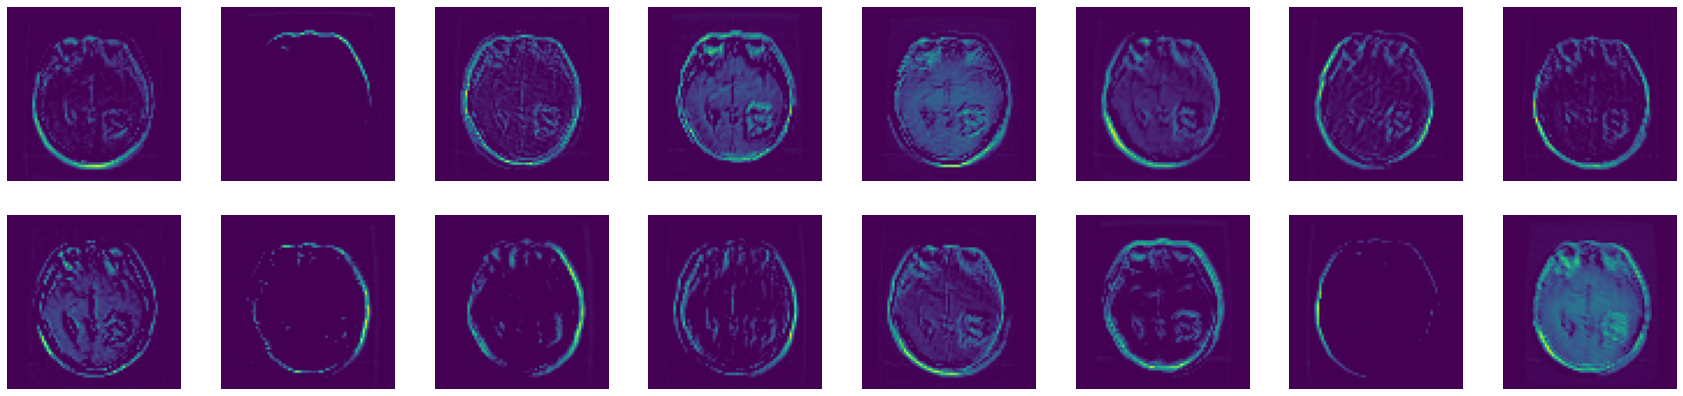

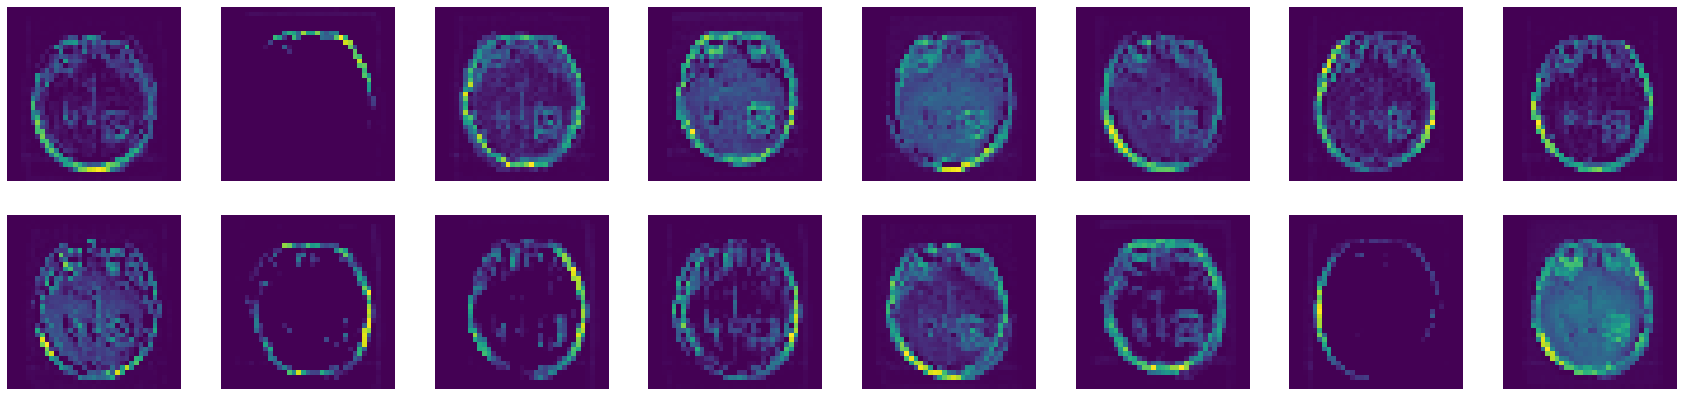

In [28]:
def display_image_filtered(name_image,model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1) 
    
    img_size = 150
    image_resize = cv2.resize(image, (img_size,img_size))
    new_image = image_resize.reshape(-1,img_size,img_size,3)
    
    f = feature_map_1.predict(new_image) 
    dim = f.shape[3]
    print(f'{layer_name} | Features Shape: {f.shape}')
    print(f'Dimension {dim}')
    fig= plt.figure(figsize=(30,30))
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')        
    for i in range(dim):
        ax = fig.add_subplot(int(dim/2),int(dim/2),i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i])
        plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg',f[0,:,:,i])

url_image = r'https://raw.githubusercontent.com/YannaelB/CNN/main/Cancer%20(8).jpg'
resp = requests.get(url_image, stream=True).raw
image_array = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array.shape}')
image_fitting = cv2.imdecode(image_array, cv2.IMREAD_COLOR)


name = 'cancer'
num = 16
plt.axis('off')
plt.imshow(cv2.cvtColor(image_fitting, cv2.COLOR_BGR2RGB))
plt.show()
for i in range(0,2):
    if num == 0 and i==0:
        print('-----------------------------------------------------')
        print(f'{i+1}st convolutionnal layer')
        display_image_filtered(name,loaded_model,f'conv2d',image_fitting)
        print('--------')
        print(f'{i-1}nd Pooling')
        display_image_filtered(name,loaded_model,f'max_pooling2d',image_fitting)
        print('-----------------------------------------------------')
    else:
        print('-----------------------------------------------------')
        print(f'{i+1}st convolutionnal layer')
        display_image_filtered(name,loaded_model,f'conv2d_{num+i}',image_fitting)
        print('--------')
        print(f'{i+1}nd Pooling')
        display_image_filtered(name,loaded_model,f'max_pooling2d_{num+i}',image_fitting)
        print('-----------------------------------------------------')


### Data augmention example

Data augmentation allow to lightly modify an object for increasing the dataset from a same amount of data. For example, a single image can be see with different zoom and point of view.

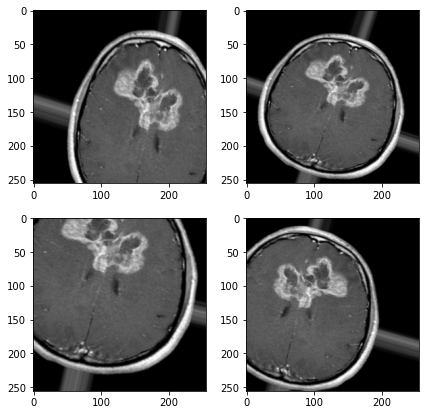

In [29]:
DA_dir = r'C:\Users\yanna\CNN\Brain_tumor\DA_dataset'

augmented_datagen = ImageDataGenerator(
    rotation_range = 40, 
    width_shift_range= 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    fill_mode = 'nearest') 

f_names = [os.path.join(DA_dir, f_name) for f_name in os.listdir(DA_dir)]

img_path = f_names[4]
img = image.load_img(img_path, target_size=(256, 256))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(7,7))
plt.axis('off')


for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4 :
     break

plt.show()

## Using a train model 

In [30]:
img_path = input("entrer l'adresse de votre image à tester :")

entrer l'adresse de votre image à tester :cerveau3.jpg


1/1 [==============================] - 0s 219ms/step


Text(0.5, 1.0, 'Image appartenant à la classe :1.0 => Healthy (1)')

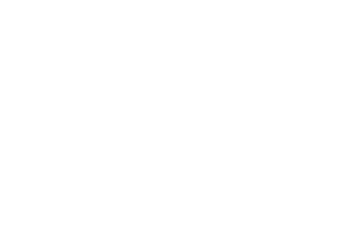

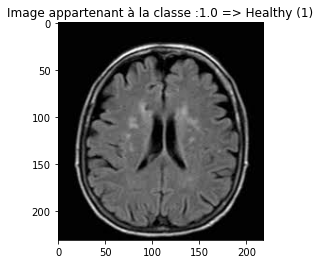

In [31]:
def prepare(filepath): #modify the image to make it useable for the network
    img_size = 150
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (img_size,img_size))
    return new_array.reshape(-1,img_size,img_size,3)

prediction = loaded_model.predict([prepare(img_path)])


if prediction[0][0] >=0.5:
    classe = "Healthy (1)"
else:
    classe = "Tumor (0)"
    
plt.axis('off')
plt.figure()
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title("Image appartenant à la classe :" +str(prediction[0][0]) +" => " + classe)